In [9]:
"""
NYC Flood → Substations → Cascade Simulation → GNN Prediction

Data Sources:
- NYC Flood Hazard GeoJSON
- OpenStreetMap NYC Power Infrastructure (OSMnx)

Pipeline:
Loads Flood GIS → Download Real Substations → Spatial Join →
Builds Infrastructure Graph → Cascade Simulation →
Trains GNN → Predict Failure Risk

Author : Shreyansh Saurabh
"""

!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install geopandas rasterio shapely networkx pandas numpy matplotlib osmnx

In [10]:
import geopandas as gpd
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import osmnx as ox

from shapely.geometry import Point
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv

In [11]:
from google.colab import drive
drive.mount('/content/drive')

flood = gpd.read_file(
"/content/drive/MyDrive/flood_project/nyc_flood_dataset.geojson"
)
print("Loaded Flood Dataset")
print(flood.head())
print("CRS:", flood.crs)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded Flood Dataset
         GEOID FSHRI FVI_storm_surge_present FVI_storm_surge_2050s  \
0  36005009200     4                    None                  None   
1  36005006400     5                    None                  None   
2  36005036501     3                    None                  None   
3  36005007900     4                    None                  None   
4  36005024700     1                    None                  None   

  FVI_storm_surge_2080s FVI_tidal_2020s FVI_tidal_2050s FVI_tidal_2080s  \
0                  None            None            None            None   
1                     5            None            None            None   
2                  None            None            None            None   
3                  None            None            None            None   
4                  None            None            Non

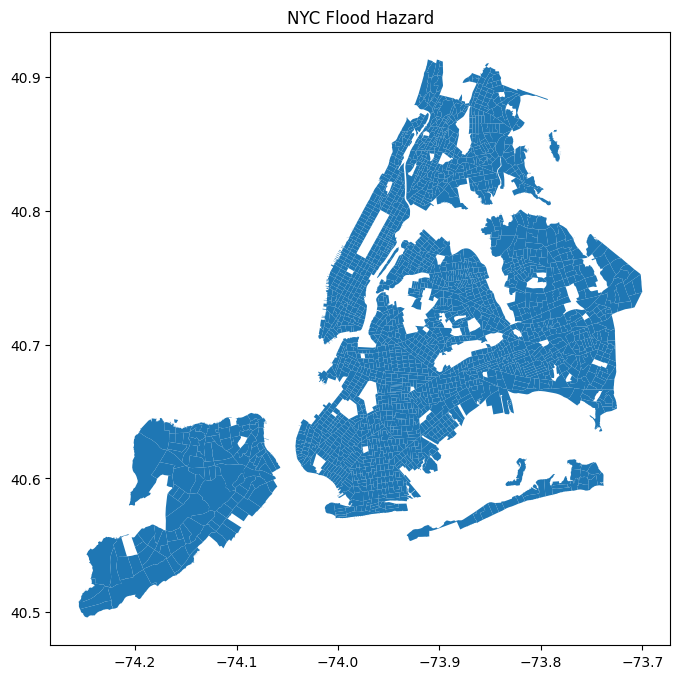

In [12]:
"""
Visualizing flood polygons
"""

flood.plot(figsize=(8,8))
plt.title("NYC Flood Hazard")
plt.show()

In [13]:
"""
Downloading NYC power substations and infrastructure from OpenStreetMap
"""

place = "New York City, New York, USA"

tags = {
    "power": ["substation", "plant", "transformer"]
}

power_raw = ox.features_from_place(place, tags)

print("Power assets downloaded:", len(power_raw))
power_raw.head()

Power assets downloaded: 240


geometry addr:state  ele  \
element id                                                       
node    368062840   POINT (-73.90291 40.80455)         NY    2   
        2985256280  POINT (-73.77086 40.67905)        NaN  NaN   
        3469169229  POINT (-73.98401 40.70385)        NaN  NaN   
        3574804123  POINT (-73.94413 40.76325)        NaN  NaN   
        3574804124   POINT (-73.94399 40.7635)        NaN  NaN   

                   gnis:feature_id                       name        power  \
element id                                                                   
node    368062840          2062029  Port Morris Power Station   substation   
        2985256280             NaN                        NaN  transformer   
        3469169229             NaN                        NaN  transformer   
        3574804123             NaN                        NaN  transformer   
        3574804124             NaN                        NaN  transformer   

                           source devices frequency location  ... disused  \
element id                                                    ...           
node    368062840   USGS Geonames     NaN       NaN      NaN  ...     NaN   
        2985256280            NaN       1        60  outdoor  ...     NaN   
        3469169229           Bing     NaN       NaN      NaN  ...     NaN   
        3574804123            NaN     NaN       NaN      NaN  ...     NaN   
        3574804124            NaN     NaN       NaN      NaN  ...     NaN   

                   architect architect:wikidata architect:wikipedia  \
element id                                                            
node    368062840        NaN                NaN                 NaN   
        2985256280       NaN                NaN                 NaN   
        3469169229       NaN                NaN                 NaN   
        3574804123       NaN                NaN                 NaN   
        3574804124       NaN                NaN                 NaN   

                   building:part website layer area man_made description  
element id                                                                
node    368062840            NaN     NaN   NaN  NaN      NaN         NaN  
        2985256280           NaN     NaN   NaN  NaN      NaN         NaN  
        3469169229           NaN     NaN   NaN  NaN      NaN         NaN  
        3574804123           NaN     NaN   NaN  NaN      NaN         NaN  
        3574804124           NaN     NaN   NaN  NaN      NaN         NaN  

[5 rows x 67 columns]

In [14]:
"""
Converts substations / plants to centroid points
"""

power_points = power_raw.copy()
power_points["geometry"] = power_points.geometry.centroid
power_points = power_points[["geometry"]].reset_index(drop=True)

/tmp/ipython-input-3325919545.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  power_points["geometry"] = power_points.geometry.centroid


In [15]:
"""
Ensures CRS alignment before spatial join
"""

power_points = power_points.set_crs("EPSG:4326", allow_override=True)
power_points = power_points.to_crs(flood.crs)

In [16]:
"""
Maps flood exposure to real substations
"""

power_flood = gpd.sjoin(
power_points,
flood,
how="left",
predicate="intersects"
)

power_flood["flood_exposed"] = power_flood.index_right.notnull().astype(int)

print(power_flood.head())

                     geometry  index_right        GEOID FSHRI  \
0  POINT (-73.90291 40.80455)          NaN          NaN   NaN   
1  POINT (-73.77086 40.67905)        240.0  36081033401     2   
2  POINT (-73.98401 40.70385)       2092.0  36047002100     1   
3  POINT (-73.94413 40.76325)          NaN          NaN   NaN   
4   POINT (-73.94399 40.7635)          NaN          NaN   NaN   

  FVI_storm_surge_present FVI_storm_surge_2050s FVI_storm_surge_2080s  \
0                     NaN                   NaN                   NaN   
1                    None                  None                  None   
2                       2                     2                     2   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   

  FVI_tidal_2020s FVI_tidal_2050s FVI_tidal_2080s  flood_exposed  
0             NaN             NaN             NaN              0  
1            None            None   

In [40]:
"""
Builds graph by connecting nearby substations
"""

coords = np.array([
(p.x, p.y) for p in power_flood.geometry
])

G = nx.Graph()

for i in range(len(coords)):
    G.add_node(i)

threshold = 0.02

for i in range(len(coords)):
    for j in range(i+1, len(coords)):
        dist = np.linalg.norm(coords[i]-coords[j])
        if dist < threshold:
            G.add_edge(i,j)

print("Graph Nodes:", G.number_of_nodes())
print("Graph Edges:", G.number_of_edges())

Graph Nodes: 240
Graph Edges: 676


In [25]:
"""
Attaches flood exposure + synthetic load features
"""

for i,node in enumerate(G.nodes()):
    G.nodes[node]["flood"] = power_flood.iloc[i]["flood_exposed"]
    G.nodes[node]["load"] = np.random.uniform(0.5,1.5)

In [26]:
"""
Simulates cascading failures triggered by flood exposure
"""

def simulate_cascade(G):

    failed=set()

    for node in G.nodes():
        if G.nodes[node]["flood"]==1:
            if np.random.rand()<0.5:
                failed.add(node)

    changed=True
    while changed:
        changed=False
        for node in G.nodes():
            if node in failed: continue

            neigh=list(G.neighbors(node))
            f=sum([1 for n in neigh if n in failed])

            if f>0 and np.random.rand()<0.2*f:
                failed.add(node)
                changed=True

    return failed

In [27]:
"""
Generates failure labels from cascade simulation
"""

labels=np.zeros(len(G.nodes()))
failed=simulate_cascade(G)

for node in failed:
    labels[node]=1

In [28]:
"""
Converts graph + features to GNN training format
"""

for node in G.nodes():
    G.nodes[node]["feature"]=[
        G.nodes[node]["flood"],
        G.nodes[node]["load"]
    ]

data=from_networkx(G)

data.x=torch.tensor(
[G.nodes[n]["feature"] for n in G.nodes()],
dtype=torch.float
)

data.y=torch.tensor(labels,dtype=torch.long)

In [29]:
"""
Graphs Neural Network for failure prediction
"""

class GNN(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1=GCNConv(2,16)
        self.conv2=GCNConv(16,2)

    def forward(self,data):
        x,edge=data.x,data.edge_index
        x=self.conv1(x,edge)
        x=F.relu(x)
        x=self.conv2(x,edge)
        return x

In [30]:
"""
Trains GNN model
"""

model=GNN()
opt=torch.optim.Adam(model.parameters(),lr=0.01)

for epoch in range(100):
    opt.zero_grad()
    out=model(data)
    loss=F.cross_entropy(out,data.y)
    loss.backward()
    opt.step()

    if epoch%10==0:
        print(epoch,loss.item())

0 0.6500937342643738
10 0.3466988801956177
20 0.32647910714149475
30 0.3269478678703308
40 0.31832119822502136
50 0.3187004625797272
60 0.3168480098247528
70 0.3159354031085968
80 0.3146042823791504
90 0.31326374411582947


In [31]:
"""
Predicts failure probability for each infrastructure node
"""

model.eval()
pred=model(data)
prob=torch.softmax(pred,dim=1)

print("Failure Probabilities:")
print(prob[:10])

Failure Probabilities:
tensor([[0.1773, 0.8227],
        [0.0834, 0.9166],
        [0.0883, 0.9117],
        [0.1189, 0.8811],
        [0.1189, 0.8811],
        [0.0982, 0.9018],
        [0.0982, 0.9018],
        [0.0982, 0.9018],
        [0.0982, 0.9018],
        [0.0939, 0.9061]], grad_fn=<SliceBackward0>)


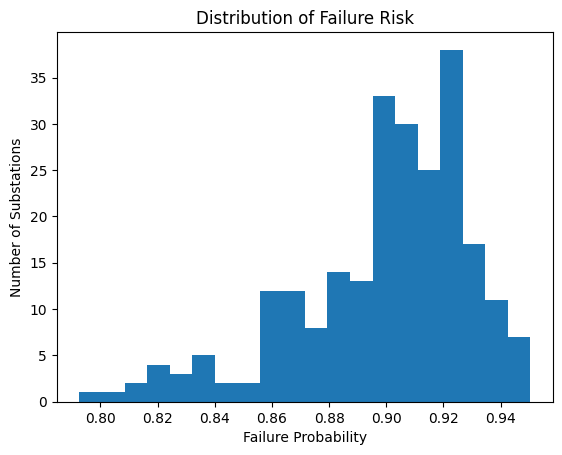

In [32]:
"""
Ploting histogram of predicted failure probabilities
"""

fail_prob = prob[:,1].detach().numpy()

plt.hist(fail_prob, bins=20)
plt.title("Distribution of Failure Risk")
plt.xlabel("Failure Probability")
plt.ylabel("Number of Substations")
plt.show()

In [34]:
print(flood.columns)

Index(['GEOID', 'FSHRI', 'FVI_storm_surge_present', 'FVI_storm_surge_2050s',
       'FVI_storm_surge_2080s', 'FVI_tidal_2020s', 'FVI_tidal_2050s',
       'FVI_tidal_2080s', 'geometry'],
      dtype='object')


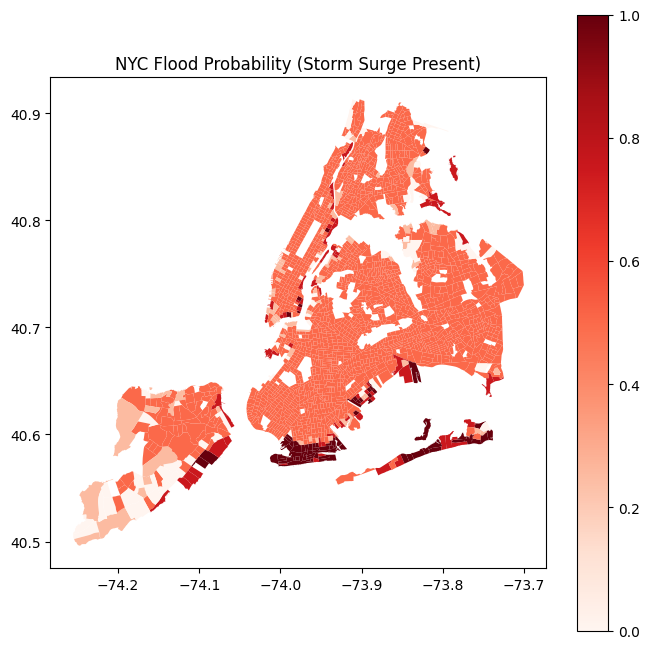

In [39]:
"""
Creating Flood Probability Map

Uses: FVI_storm_surge_present
"""

import pandas as pd
import matplotlib.pyplot as plt

score = pd.to_numeric(
    flood["FVI_storm_surge_present"],
    errors="coerce"
)

score = score.fillna(score.mean())
flood["flood_prob"] = (score - score.min()) / (score.max() - score.min())


flood.plot(
    column="flood_prob",
    cmap="Reds",
    legend=True,
    figsize=(8,8)
)

plt.title("NYC Flood Probability (Storm Surge Present)")
plt.show()